## SOM

Encontrando clusters que com taxa de prematuridades `ptb rate` altas e baixas utilizando mapas auto-organizáveis `SOM`.

**Instala biblioteca MiniSom**
https://github.com/JustGlowing/minisom

In [2]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.7-cp37-none-any.whl size=8609 sha256=bb07fccfd496b0e1e58ea65ec4bd9f6298e8c7478053cdda203d557a536d1ddd
  Stored in directory: /root/.cache/pip/wheels/db/9a/af/0fca4ced67fec66c00998c4bf55b13f0a4c882ee775f278862
Successfully built minisom


In [3]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Clusterização
from minisom import MiniSom
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, PowerTransformer
from sklearn.metrics import classification_report

**Carregamento de dados preprocessados do SINASC e CADU, agrupados por id municipal**

In [5]:
df = pd.read_csv("/content/drive/My Drive/The Sound of Drums/Notebooks/data/pos_means1.csv", index_col=0)
df.sample()

,idade,val_remuner_emprego_memb,val_renda_bruta_12_meses_memb,val_renda_doacao_memb,val_renda_aposent_memb,val_renda_seguro_desemp_memb,val_renda_pensao_alimen_memb,val_outras_rendas_memb,cod_sexo_pessoa_2,cod_raca_cor_pessoa_1.0,cod_raca_cor_pessoa_2.0,cod_raca_cor_pessoa_3.0,cod_raca_cor_pessoa_4.0,cod_raca_cor_pessoa_5.0,cod_local_nascimento_pessoa_1.0,cod_local_nascimento_pessoa_2.0,cod_local_nascimento_pessoa_3.0,cod_certidao_registrada_pessoa_1,cod_certidao_registrada_pessoa_2,cod_certidao_registrada_pessoa_3,cod_certidao_registrada_pessoa_4,cod_deficiencia_memb_1,cod_deficiencia_memb_2,cod_sabe_ler_escrever_memb_1.0,cod_sabe_ler_escrever_memb_2.0,ind_frequenta_escola_memb_1.0,ind_frequenta_escola_memb_2.0,ind_frequenta_escola_memb_3.0,ind_frequenta_escola_memb_4.0,cod_escola_local_memb_1.0,cod_escola_local_memb_2.0,cod_curso_frequenta_memb_1.0,cod_curso_frequenta_memb_2.0,cod_curso_frequenta_memb_3.0,cod_curso_frequenta_memb_4.0,cod_curso_frequenta_memb_5.0,cod_curso_frequenta_memb_6.0,cod_curso_frequenta_memb_7.0,cod_curso_frequenta_memb_8.0,cod_curso_frequenta_memb_9.0,...,cod_escoa_sanitario_domic_fam_6.0,cod_destino_lixo_domic_fam_1.0,cod_destino_lixo_domic_fam_2.0,cod_destino_lixo_domic_fam_3.0,cod_destino_lixo_domic_fam_4.0,cod_destino_lixo_domic_fam_5.0,cod_destino_lixo_domic_fam_6.0,cod_iluminacao_domic_fam_1.0,cod_iluminacao_domic_fam_2.0,cod_iluminacao_domic_fam_3.0,cod_iluminacao_domic_fam_4.0,cod_iluminacao_domic_fam_5.0,cod_iluminacao_domic_fam_6.0,cod_calcamento_domic_fam_1.0,cod_calcamento_domic_fam_2.0,cod_calcamento_domic_fam_3.0,cod_familia_indigena_fam_1,cod_familia_indigena_fam_2,ind_familia_quilombola_fam_1.0,ind_familia_quilombola_fam_2.0,ind_parc_mds_fam_0.0,ind_parc_mds_fam_101.0,ind_parc_mds_fam_201.0,ind_parc_mds_fam_202.0,ind_parc_mds_fam_203.0,ind_parc_mds_fam_204.0,ind_parc_mds_fam_205.0,ind_parc_mds_fam_301.0,ind_parc_mds_fam_302.0,ind_parc_mds_fam_303.0,ind_parc_mds_fam_304.0,ind_parc_mds_fam_305.0,ind_parc_mds_fam_306.0,marc_pbf_0,marc_pbf_1,cod_familia_indigena_fam_1.0,cod_familia_indigena_fam_2.0,ptb_rate,early_ptb_rate,extr_ptb_rate
cd_ibge,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4112207,26.386364,192.454545,4289.863636,5.454545,60.545455,0.0,0.0,0.0,1.0,0.636364,0.022727,0.0,0.340909,0.0,0.522727,0.477273,0.0,0.977273,0.022727,0.0,0.0,0.022727,0.977273,0.954545,0.045455,0.204545,0.0,0.795455,0.0,0.204545,0.0,0.0,0.0,0.0,0.0,0.022727,0.022727,0.159091,0.0,0.0,...,0.0,0.897436,0.076923,0.025641,0.0,0.0,0.0,0.923077,0.076923,0.0,0.0,0.0,0.0,0.307692,0.128205,0.564103,0.0,1.0,0.0,1.0,0.897436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589744,0.410256,0.0,0.0,0.001296,0.00037,0.00037


**Remoção de colunas que não agregam ao agrupamento**

In [6]:
df.drop(columns=['cd_ibge', 'id_familia', 'ind_parc_mds_fam', 'cod_parentesco_rf_pessoa', 
                 'cod_local_nascimento_pessoa', 'cod_certidao_registrada_pessoa', 
                 'ind_frequenta_escola_memb', 'cod_escola_local_memb'], inplace=True, errors='ignore')

**Remoção de municípios com frequências extremamente altas ou baixas de nascimentos prematuros**

Alguns dados, especialmente de municípios menores podem estar muito fora da curva

In [7]:
df = df[(df.ptb_rate < df.ptb_rate.quantile(0.95)) & (df.ptb_rate > df.ptb_rate.quantile(0.05))]
y_feat = 'ptb_rate'
Y_feat = ['ptb_rate', 'early_ptb_rate', 'extr_ptb_rate']
X = df.copy()#.drop(columns=Y_feat)
X[:] = MinMaxScaler().fit_transform(PowerTransformer().fit_transform(Normalizer().fit_transform(X)))
Y = df[[y_feat]].copy()
Y[:] = MinMaxScaler().fit_transform(Y)

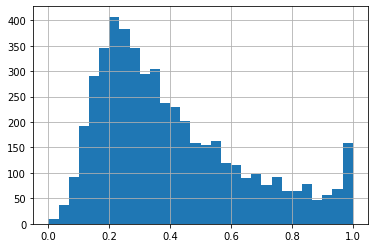

In [50]:
X.ptb_rate.hist(bins=30)

https://www.researchgate.net/publication/293651133_A_New_Method_for_an_Optimal_SOM_Size_Determination_in_Neuro-Fuzzy_for_the_Digital_Forensics_Applications

In [9]:
corrX = pd.DataFrame(MinMaxScaler().fit_transform((Normalizer().fit_transform(df)))).corr()
absolute_mean = corrX.mean().mean()

In [10]:
eigenvalues = np.linalg.eigvals(corrX)
eigenvalues = eigenvalues.flatten()
eigenvalues.sort()
print(eigenvalues.real[:5])
eigenratio = eigenvalues[0].real/eigenvalues[1].real
degree_of_randomness = eigenratio * absolute_mean * 2
degree_of_randomness

[-2.83836799e-14 -1.98138764e-14 -1.50154814e-14 -1.21017715e-14
 -9.92580748e-15]


0.6273569268047755

In [11]:
Smin = 4
Smax = 25

S = Smin + degree_of_randomness*(Smax-Smin)

Sa = np.sqrt(S)
Sb = S/Sa

In [12]:
som_grid = np.int64((np.ceil(Sa), np.ceil(Sb)))
som_grid

array([5, 5])

In [13]:
np.sqrt(5*np.sqrt(X.shape[0]))

18.779467497552936

In [14]:
som2 = MiniSom(*som_grid, len(X.columns), sigma=1, learning_rate=.1,
              neighborhood_function='gaussian', activation_distance='cosine')
som2.pca_weights_init(X.to_numpy())

qerror = 10000
forget = 0
while True:
    som2.train_random(X.to_numpy(), 100000, verbose=False)
    qerror_b = som2.quantization_error(X.to_numpy())
    if qerror_b > qerror:
        forget += 1
        if forget > 2: 
            print(qerror_b)
            break
    else:
        qerror = qerror_b
        forget = 0

    print(qerror_b)

2.8512840188156368
2.844720001564957
2.861050412484079
2.8432328247483687
2.8522621904380596
2.844807662995303
2.840381178264032
2.8484488999875888
2.8454627902662613
2.838849990684893
2.841271964663181
2.850931981389023
2.84332409537561


In [15]:
winmap2 = som2.labels_map(X.to_numpy(), Y)

In [16]:
w_x, w_y = zip(*[som2.winner(d) for d in X.to_numpy()])
w_x = np.array(w_x)
w_y = np.array(w_y)

winner_coordinates  = np.array([som2.winner(d) for d in X.to_numpy()]).T

In [17]:
cluster_index = np.ravel_multi_index(winner_coordinates, (20,20))

In [18]:
cX = df.copy()
cX['high'] = cX.ptb_rate.apply(lambda x : x > cX.ptb_rate.quantile(.75))
cX['low'] = cX.ptb_rate.apply(lambda x : x < cX.ptb_rate.quantile(.25))
# cX['Q'] = cX.ptb_rate.apply(lambda x : (x > cX.ptb_rate.quantile([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])).sum())

In [20]:
cX['cluster'] = cluster_index
cX.groupby('cluster').agg({'low':'sum', 'high':'sum', 'ptb_rate':'mean', 'idade':'count'})

,low,high,ptb_rate,idade
cluster,,,,
0,17,97,0.001746,180
1,28,73,0.001622,168
2,46,34,0.001329,158
3,38,34,0.001381,131
4,43,43,0.001414,165
20,25,53,0.001503,172
21,27,48,0.001468,185
22,69,41,0.001318,192
23,36,24,0.001356,121


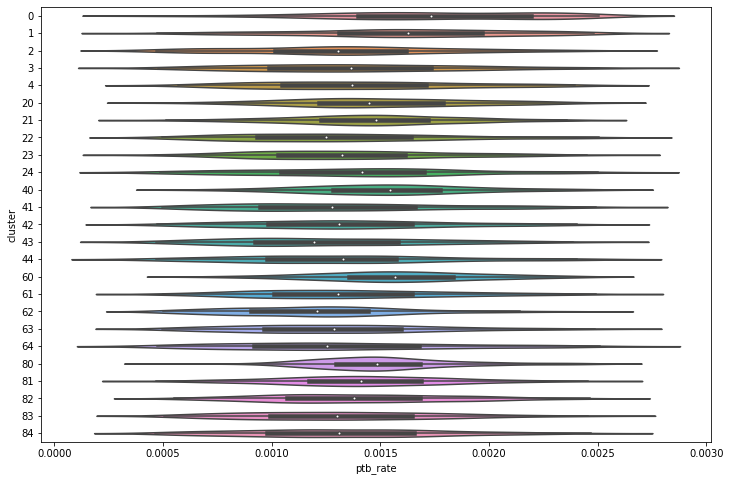

In [21]:
plt.subplots(figsize=(12,8))
sns.violinplot(x=cX.ptb_rate, y=cX.cluster, orient='h')

plt.show()

In [22]:
pca = PCA(n_components=3)
selection = X.copy()
pca.fit(selection)
selection[['pca_f1', 'pca_f2', 'pca_f3']] = pca.fit_transform(selection)

x = selection['pca_f1']
y = selection['pca_f2']
z = selection['pca_f3']# RobustScaler().fit_transform(df2[['ptb_rate']])
c = cluster_index

In [23]:
import plotly.express as px
fig = px.scatter_3d(x=x, y=y, z=z, color=cluster_index, opacity=1)
fig.show()

In [24]:
target = (np.int64(Y > Y.quantile(0.25)) + 2*np.int64(Y < Y.quantile(0.75)))[:,0]

In [25]:
pd.DataFrame(list(zip(cluster_index, target, target)),  columns=['cluster', 'target', 'c']).groupby(['cluster', 'target']).count().head(15)

c
cluster target    
0       1       97
        2       17
        3       66
1       1       73
        2       28
        3       67
2       1       34
        2       46
        3       78
3       1       34
        2       38
        3       59
4       1       43
        2       43
        3       79

In [26]:
label_names = ['low', 'high', 'mid']

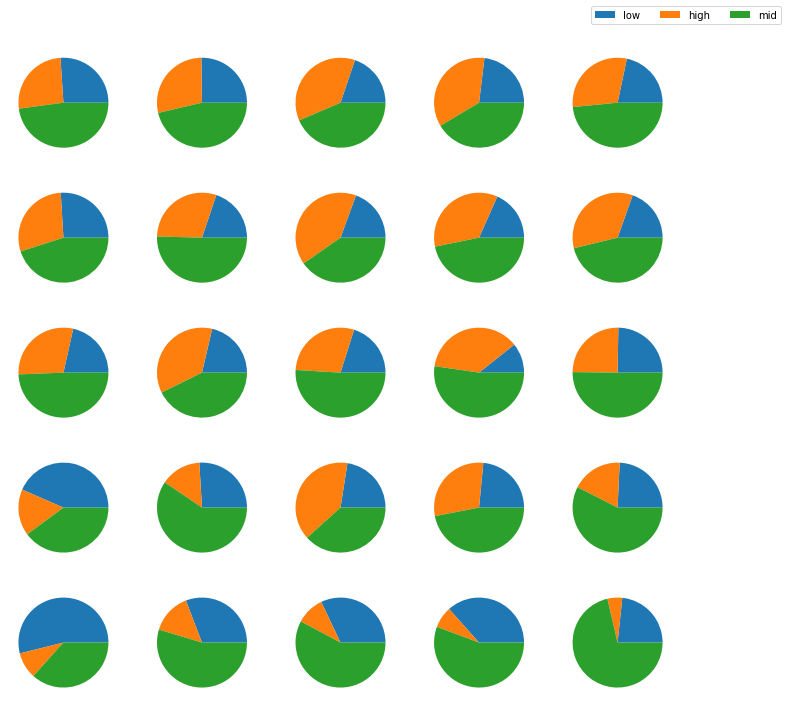

In [30]:
import matplotlib.gridspec as gridspec

labels_map = som2.labels_map(X.to_numpy(), [label_names[t-1] for t in target])

fig = plt.figure(figsize=(12, 12))
the_grid = gridspec.GridSpec(*som_grid, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[som_grid[0]-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names, bbox_to_anchor=(2, 5), ncol=3)
# plt.savefig('resulting_images/som_seed_pies.png')
plt.show()

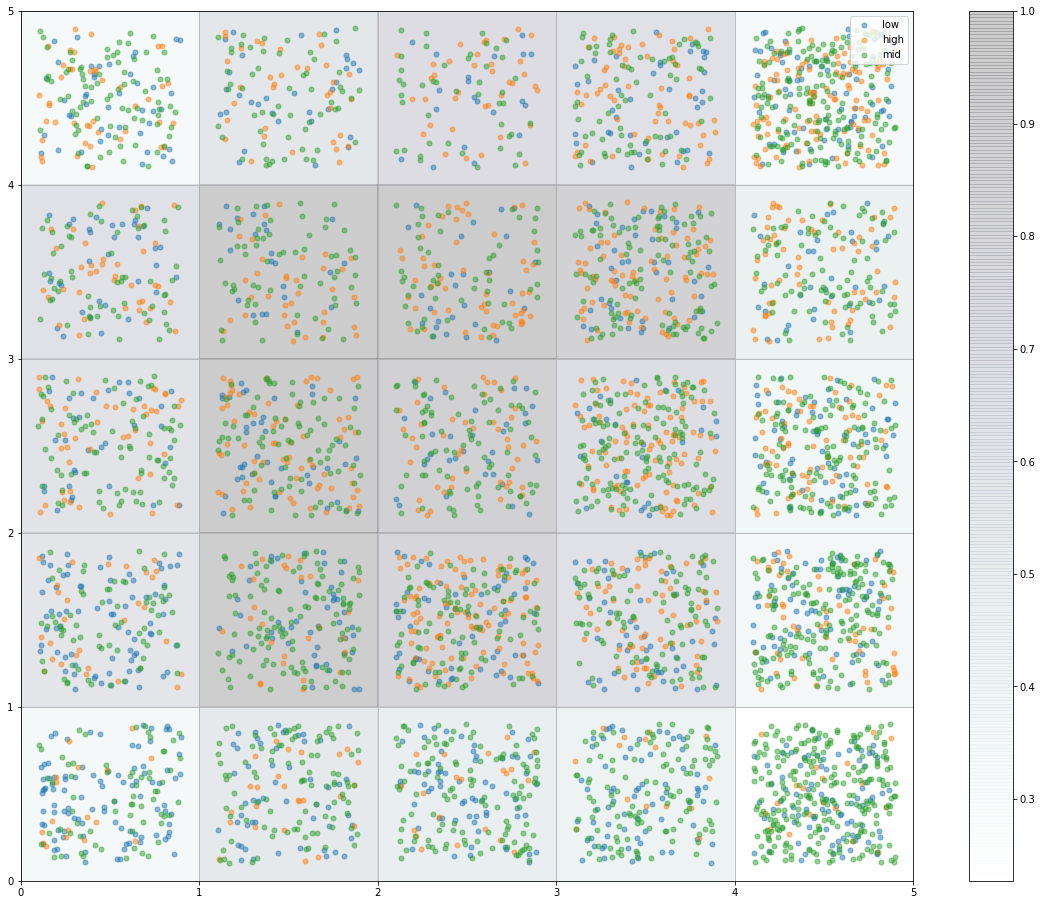

In [31]:
w_x, w_y = zip(*[som2.winner(d) for d in X.to_numpy()])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(20, 16))
plt.pcolor(som2.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=25, c=colors[c-1], label=label_names[c-1], alpha=.5)
plt.legend(loc='upper right')
plt.grid()
# plt.savefig('resulting_images/som_seed.png')
plt.show()

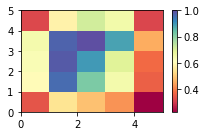

In [32]:
plt.subplots(figsize=(3,2))

plt.subplot(1,1,1)
plt.pcolor(som2.distance_map().T, cmap='Spectral', alpha=1)
plt.colorbar()

plt.tight_layout()
plt.show()

In [33]:
cX['Q'] = cX.ptb_rate.apply(lambda x : (x > cX.ptb_rate.quantile([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])).sum())

In [34]:
distribuitions = cX.groupby(['cluster', 'Q'])[['ptb_rate']].count().div(cX.groupby(['cluster'])[['ptb_rate']].count()).reset_index().pivot(columns='Q', index='cluster', values='ptb_rate').fillna(0)

Aqueles grupos de municípios que tiverem mais que 45% de suas FNPs nas três faixas mais altas são tratados como grupos de FNP alto.

Já os grupos de municípios que tiverem mais que 45% de suas FNPs nas três faixas mais baixas são tratados como grupos de FNP baixo.

Regra sujeita a mudança.

In [35]:
distribuitions = distribuitions.reset_index().drop(columns='cluster')

In [36]:
large_ptb_rate_groups = distribuitions[(distribuitions[8] + distribuitions[9] + distribuitions[10] > 0.4)].index.values
small_ptb_rate_groups = distribuitions[(distribuitions[0] + distribuitions[1] + distribuitions[2] + distribuitions[3] > 0.4)].index.values

groups_to_analyse = list(large_ptb_rate_groups) + list(small_ptb_rate_groups)

In [37]:
groups_to_analyse

[0, 1, 15, 11, 13, 14, 17, 18]

Grupos de destaque, é possível observar no gráfico 3d acima que alguns destes clusters ficam muito bem definidos graficamente utilizando PCA.

In [38]:
cX.groupby(['cluster'])[['ptb_rate']].count().iloc[groups_to_analyse]

,ptb_rate
cluster,
0,180
1,168
60,194
41,253
43,134
44,101
62,262
63,218


É calculada a diferença média entre os clusters com valores de FNP altos e baixos em relação aos valores médios dos clusters "normais".

No teste abaixo, observa-se então as características que mais favorecem o aumento da FNP. E através do dicionário de variáveis do CADU, podemos descobrir o significado destas características. Ex.:

* cod_escoa_sanitario_fam_4 -> vala ou céu aberto
* cod_abaste_agua_domic_fam_2 -> poço ou nascente
* cod_agua_canalizada_fam_2 -> Não
* ind_familia_quilombola_fam_1 -> Sim
* cod_banheiro_domic_fam_2 -> Não
* cod_destino_lixo_domic_fam_3 -> Queimado ou enterrado na propriedade
* cod_destino_lixo_domic_fam_4 -> Jogado em terreno baldio ou logradouro
* cod_material_piso_fam_1 -> Terra
* cod_iluminacao_domic_fam_3 -> Elétrica sem medidor
* cod_iluminacao_domic_fam_4 -> Óleo/querosene/gás
* cod_calcamento_domic_fam_3 -> Não existe
* cod_agricultura_trab_memb_1 -> Sim (atividade extratisvista)
* cod_material_domic_fam_5 -> Taipa não revestida
* cod_destino_lixo_domic_fam_5 -> É jogado no rio/mar
* cod_raca_cor_pessoa_4 -> Parda
* cod_curso_frequenta_memb_5 -> Fundamental
* cod_curso_frequentou_pessoa_memb_1 -> Creche

In [39]:
cluster_centers = np.array([cX[cX.cluster == cl].mean() for cl in cX.cluster.unique()])
cluster_centers = cluster_centers[:, :-7]

In [40]:
mm = MinMaxScaler().fit(cluster_centers)
large_centers = mm.transform(cluster_centers[large_ptb_rate_groups]).mean(axis=0)
small_centers = mm.transform(cluster_centers[small_ptb_rate_groups]).mean(axis=0)
other_centers = mm.transform(cluster_centers[list(set(distribuitions.index) - set(large_ptb_rate_groups) - set(small_ptb_rate_groups))]).mean(axis=0)

array([ 0,  1, 15])

In [48]:
for cent in large_ptb_rate_groups:
    mm.transform(cluster_centers[[cent]]).mean()

In [41]:
arr = pd.Series((large_centers - other_centers))
arr.index = selection.columns[:-6]

vdf1 = pd.DataFrame(arr.sort_values(ascending=False).head(50)).reset_index()
vdf1.columns = ['maior_destaque_pos', 'val_pos']

vdf2 = pd.DataFrame(arr.sort_values(ascending=False).tail(50).sort_values(ascending=True)).reset_index()
vdf2.columns = ['maior_destaque_neg', 'val_neg']

vdf = vdf1.join(vdf2)
vdf['pos'] = vdf.index+1
vdf.set_index('pos').head(20)

,maior_destaque_pos,val_pos,maior_destaque_neg,val_neg
pos,,,,
1,ind_parc_mds_fam_304.0,0.531475,cod_raca_cor_pessoa_1.0,-0.270305
2,cod_ano_serie_frequentou_memb_9.0,0.472415,cod_agua_canalizada_fam_1.0,-0.254453
3,cod_curso_frequentou_pessoa_memb_12.0,0.456325,cod_concluiu_frequentou_memb_1.0,-0.251249
4,cod_curso_frequentou_pessoa_memb_6.0,0.435617,ind_familia_quilombola_fam_2.0,-0.248315
5,cod_curso_frequenta_memb_11.0,0.424684,val_renda_pensao_alimen_memb,-0.247993
6,cod_destino_lixo_domic_fam_5.0,0.377615,cod_curso_frequentou_pessoa_memb_5.0,-0.243503
7,cod_curso_frequentou_pessoa_memb_10.0,0.358537,cod_material_piso_fam_5.0,-0.231875
8,cod_curso_frequentou_pessoa_memb_11.0,0.348489,cod_abaste_agua_domic_fam_1.0,-0.225083
9,cod_material_domic_fam_7.0,0.335671,cod_curso_frequenta_memb_3.0,-0.224245


* cod_calcamento_domic_fam_2 -> Parcial
* cod_curso_frequentou_pessoa_memb_3 -> Alfabetização
* cod_iluminacao_domic_fam_6 -> Outra forma
* cod_escoa_sanitario_domic_fam_4 -> Vala a céu aberto
* cod_curso_frequentou_pessoa_memb_11 -> Fundamental II
* cod_destino_lixo_domic_fam_6 -> Outro destino
* cod_sabe_ler_escrever_memb_2 -> Não
* cod_curso_frequentou_pessoa_memb_10 -> Fundamental I
* cod_especie_domic_fam_3 -> Coletivo
* cod_local_domic_fam_2 -> Rurais
* cod_familia_indigena_fam_2 -> Não
* ind_familia_quilombola_fam_2 -> Não
* cod_raca_cor_pessoa_2 -> Preta
* cod_curso_frequentou_pessoa_memb_12 -> Ens. Médio
* cod_agricultura_trab_memb_1 -> Sim
* cod_abaste_agua_domic_fam_4 -> Outra forma
* cod_curso_frequenta_memb_2 -> Pré-escola

In [42]:
arr = pd.Series((small_centers - other_centers))
arr.index = selection.columns[:-6]

vdf1 = pd.DataFrame(arr.sort_values(ascending=False).head(50)).reset_index()
vdf1.columns = ['maior_destaque_pos', 'val_pos']

vdf2 = pd.DataFrame(arr.sort_values(ascending=False).tail(50).sort_values(ascending=True)).reset_index()
vdf2.columns = ['maior_destaque_neg', 'val_neg']

vdf = vdf1.join(vdf2)
vdf['pos'] = vdf.index+1
vdf.set_index('pos').head(20)

,maior_destaque_pos,val_pos,maior_destaque_neg,val_neg
pos,,,,
1,cod_principal_trab_memb_2.0,0.390168,marc_pbf_0,-0.344778
2,cod_agricultura_trab_memb_1.0,0.362119,cod_deficiencia_memb_1,-0.338139
3,marc_pbf_1,0.344778,vlr_renda_media_fam,-0.329796
4,cod_deficiencia_memb_2,0.338139,val_renda_pensao_alimen_memb,-0.310644
5,qtd_meses_12_meses_memb_2.0,0.335148,cod_ano_serie_frequentou_memb_7.0,-0.295837
6,cod_destino_lixo_domic_fam_4.0,0.322889,cod_curso_frequenta_memb_3.0,-0.293021
7,ind_parc_mds_fam_203.0,0.319739,cod_principal_trab_memb_4.0,-0.293016
8,cod_local_domic_fam_2.0,0.284299,cod_local_domic_fam_1.0,-0.284545
9,cod_agua_canalizada_fam_2.0,0.283976,cod_destino_lixo_domic_fam_1.0,-0.282307
